In [1]:
import numpy as np
import tensorflow.keras as keras
import pandas as pd
import sklearn
import matplotlib.pyplot as plt

from pathlib import Path

from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dropout, Dense
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer, minmax_scale, scale
from sklearn.base import TransformerMixin
from tensorflow.keras import backend as K

from tools import add_colorbar, preprocess_image, extract_masks, visualise_masks, zero_background

%matplotlib inline

In [2]:
# set paths to tif files
DATA_DIR = Path('./data')
MATERIALS = ('glass', 'stones', 'mix')
DATA_FILES = {k : DATA_DIR / f'{k}_new.tif' for k in MATERIALS}

In [3]:
# create dict containing np arrays of pixel vals for glass, stones & mix datasets
image_data = {k : np.array(Image.open(DATA_FILES[k])) for k in DATA_FILES.keys()}

## visualise absorption distributions per class

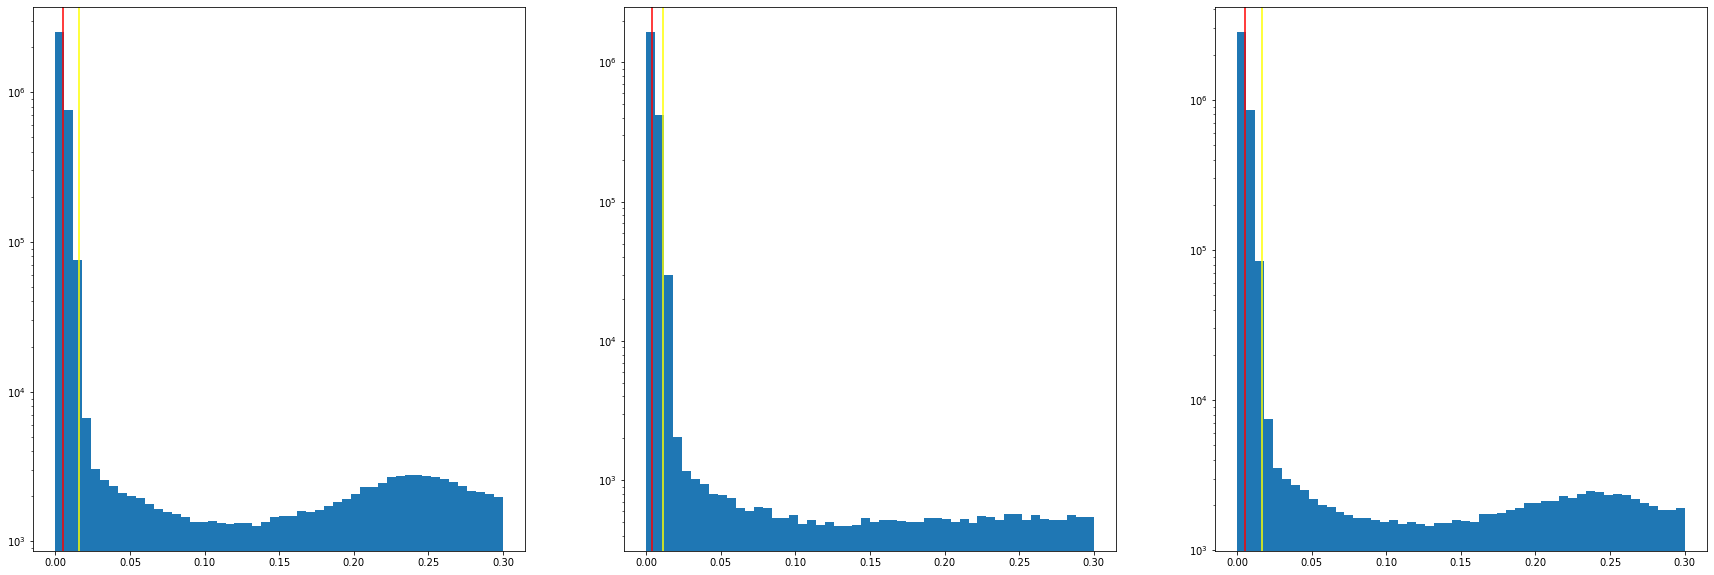

In [4]:
# plot distn of absorption
nbins = 50
xmin = 0.
xmax = 0.3

# calculate mean pixel absorptions over each data set
mean_absorption = {k:image_data[k].mean() for k in MATERIALS}

fig, axarr = plt.subplots(1, 3, figsize=(30,10));  

# plot the absorption distributions per material set
for i in range(len(MATERIALS)):
    
    mat = MATERIALS[i]
    
    axarr[i].hist(image_data[mat].flatten(),
        bins=nbins,
        range=[xmin,xmax],
        log=True)
    # mean value represented by red line
    axarr[i].axvline(mean_absorption[mat], color='red')
    # 3 x mean value by yellow
    axarr[i].axvline(3*mean_absorption[mat], color='yellow')

plt.show()

## visualise background subtraction

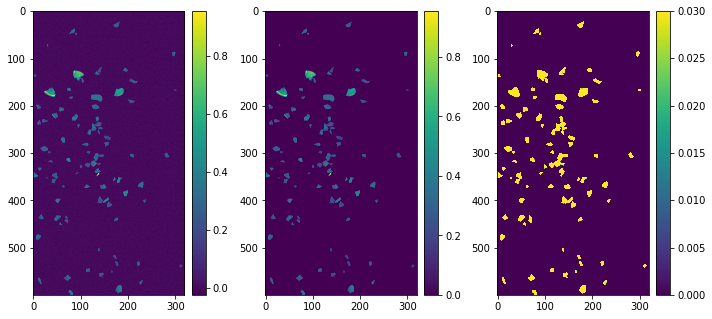

In [5]:
fig, axarr = plt.subplots(1, 3, figsize=(10,30)); 

# original image
im_orig = axarr[0].imshow(image_data['glass'][400:1000,:])
add_colorbar(im_orig)

# background (mean) subtraction
background_zerod = zero_background(image_data['glass'], mean_multiplier=4.)
im_bgs = axarr[1].imshow(background_zerod[400:1000,:])
add_colorbar(im_bgs)

# noise component
im_noise = axarr[2].imshow(background_zerod[400:1000,:], vmin=0.0, vmax=0.03)
add_colorbar(im_noise)
plt.tight_layout()
plt.show()

## preprocessing steps for raw image array

/home/liam/anaconda3/envs/vito_task/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


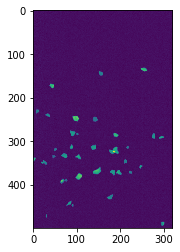

In [6]:
plt.imshow(preprocess_image(image_data['glass'][:500]))

## Assemble pipeline to extract masks

In [7]:
extract_masks(image_data['stones'])

ix_ymin  ix_ymax  ix_xmin  ix_xmax
0        5.0     20.0     -2.0      8.0
1      259.0    276.0    101.0    128.0
2      289.0    304.0    213.0    229.0
3      303.0    308.0     25.0     29.0
4      391.0    407.0    188.0    205.0
..       ...      ...      ...      ...
658  13280.0  13285.0    272.0    276.0
659  13286.0  13291.0    160.0    164.0
660  13316.0  13320.0    169.0    174.0
661  13324.0  13329.0    123.0    127.0
662  13362.0  13367.0    137.0    141.0

[663 rows x 4 columns]

## visualise bounding boxes

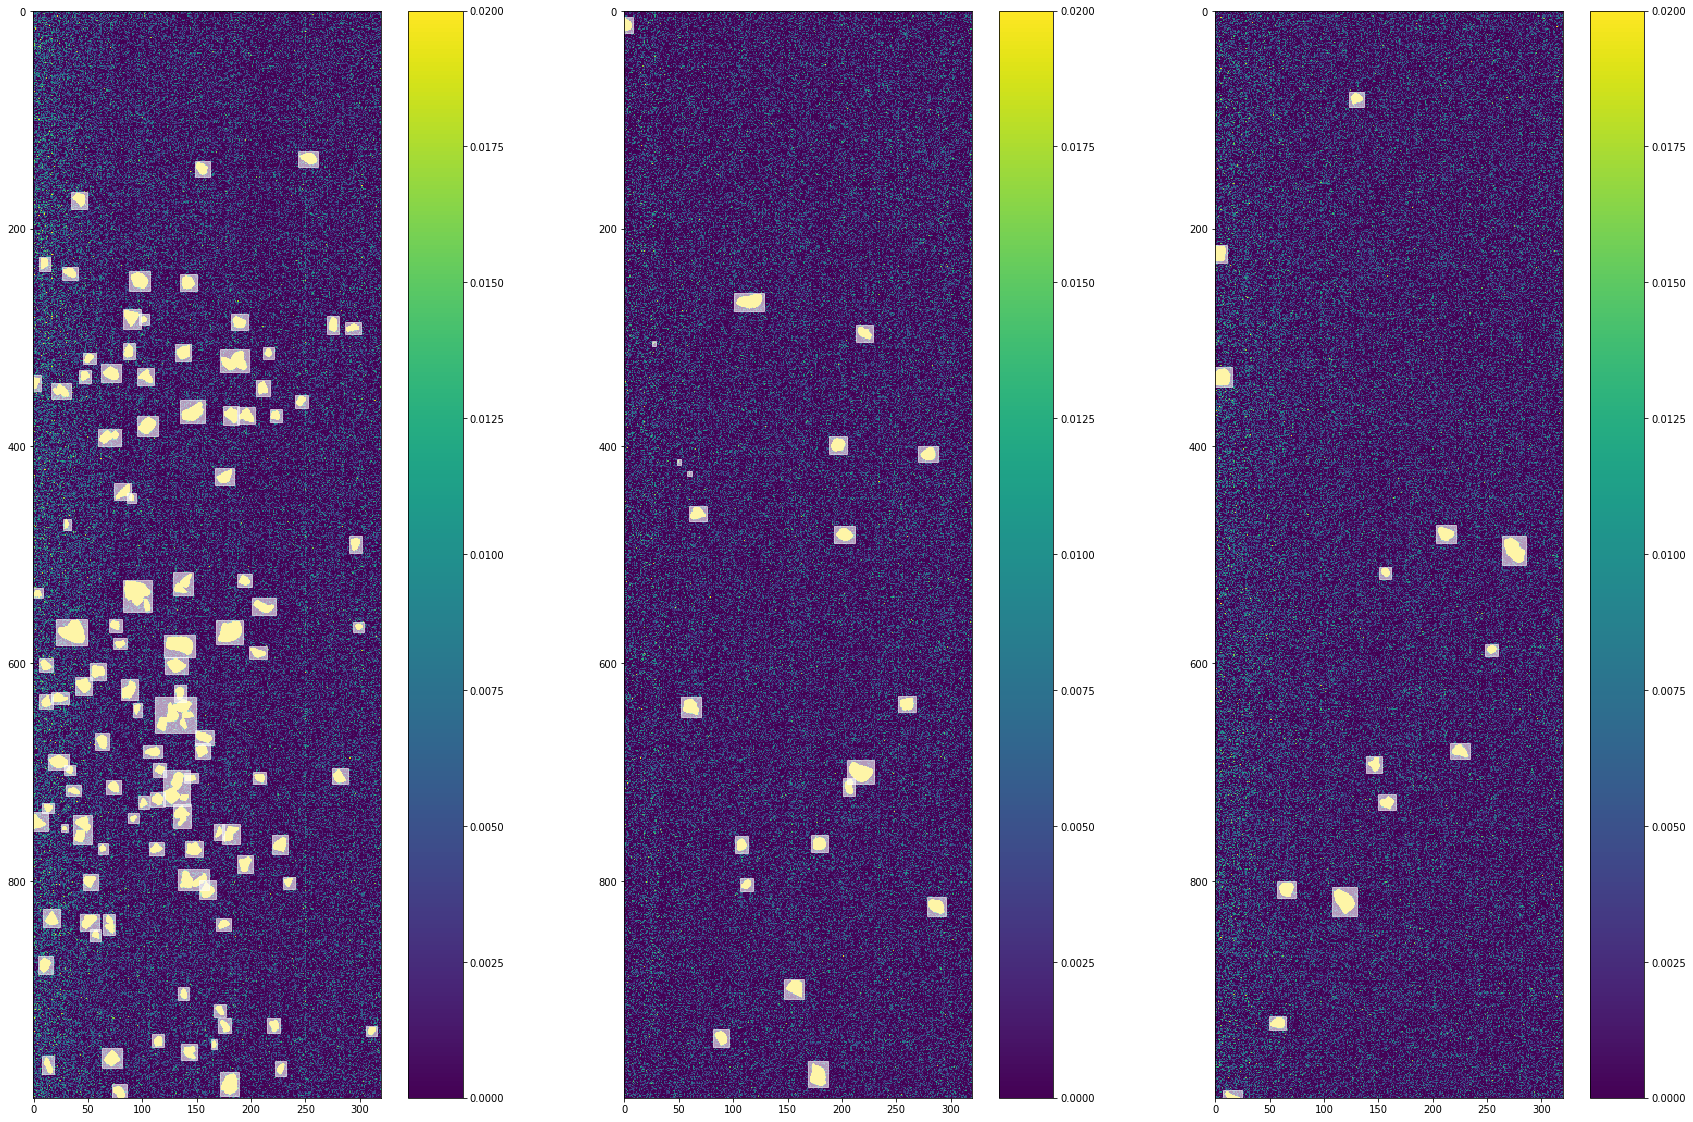

In [8]:
visualise_masks(image_data)

## rescale images and calculate masks for each object and material

In [ ]:
# we will extract the pixel regions from the rescaled images using the masks
rescaled_images = {m:preprocess_image(image_data[m]) for m in MATERIALS}
# construct masks for each image
training_masks = {m:extract_masks(image_data[m]) for m in ('glass', 'stones')}
testing_masks = extract_masks(image_data['mix'])

/home/liam/anaconda3/envs/vito_task/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/home/liam/anaconda3/envs/vito_task/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/home/liam/anaconda3/envs/vito_task/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


## resample to unbias training data

In [ ]:
# dataset is unbalanced: need to oversample stones...
for m, msk in training_masks.items():
    print(m, 'objects:', len(msk))

In [ ]:
# resample to unbias training data
max_samples = max(len(m) for m in training_masks.values())
for material, masks in training_masks.items():
    # add classification info to mask dataframe
    masks['classification'] = material
    if len(masks) < max_samples:
        training_masks[material] = masks.sample(n=max_samples, replace=True)

## define data generator

In [12]:
# combine training masks for each class into a single dataframe
df_masks = pd.concat([v for v in training_masks.values()])
# binarise labels
df_masks['binary_classification'] = (df_masks['classification'] == 'glass').astype(np.int32)
df_masks.head()

ix_ymin  ix_ymax  ix_xmin  ix_xmax classification  binary_classification
0    129.0    143.0    243.0    262.0          glass                      1
1    138.0    153.0    148.0    162.0          glass                      1
2    166.0    182.0     34.0     49.0          glass                      1
3    226.0    239.0      5.0     15.0          glass                      1
4    235.0    247.0     26.0     41.0          glass                      1

In [13]:
# generator function to return images batchwise
def generator(training_images, df_training_masks, should_augment=False, batch_size=30):
    """ yield batches of training images corresponding to boxed regions of the larger
        stone and glass image samples, along with their corresponding labels
    """
    while True:
        # shuffle masks
        df_training_masks = df_training_masks.sample(frac=1)
        # loop over batch start indices (strides of batch_size)
        for batch in range(0, len(df_training_masks), batch_size):
            # initialise numpy arrays for training batches 
            X_train, y_train = np.array([]), np.array([])
            # slice out the current batch of masks according to batch-size
            current_batch = df_training_masks.iloc[batch:(batch + batch_size)]
            # calculate width and height of largest image in batch
            current_batch['width'] = current_batch['ix_xmax'] - current_batch['ix_xmin']
            current_batch['height'] = current_batch['ix_ymax'] - current_batch['ix_ymin']
            max_width = current_batch['width'].max()
            max_height = current_batch['height'].max()
            # scale each image to size of largest mask in batch so all same size
            for ix, mask in current_batch.iterrows():
                # get the classification of this image
                classification = mask['classification']
                # look up corresponding mask indices in main source image and get pixel vals
                _img = Image.fromarray(
                    training_images[classification][
                        int(mask['ix_ymin']):int(mask['ix_ymax']), int(mask['ix_xmin']):int(mask['ix_xmax'])
                    ]
                )
                X_train = np.append(X_train,
                    np.array(_img.resize((max_height, max_width))),
                    axis=0
                )   
            # extract labels
            y_train = current_batch['binary_classification'].values

            yield (X_train, y_train)

In [14]:
train_gen = generator(rescaled_images, df_masks)

In [15]:
next(train_gen)

/home/liam/anaconda3/envs/vito_task/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/liam/anaconda3/envs/vito_task/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


TypeError: integer argument expected, got float

# Unfinished

## CNN for classification

In [ ]:
input = Input(shape=(None, None,3))

def build_cnn_classifier(n_conv_stacks=2,
                         kernel_size=(2,2),
                         pool_size=(2,2),
                         dense_nodes=32,
                         filters=16,
                         dropout=0.25):
    """
    """
    model = Sequential()
    model.add(Conv2D(filters, kernel_size=kernel_size,
                     activation='relu',
                     input_shape=(None, None, 1))) 
    model.add(Conv2D(2*filters, kernel_size, activation='relu'))
    model.add(MaxPooling2D(pool_size=pool_size))
    model.add(Dropout(dropout))
    model add(GlobalAveragePooling2D())
    model.add(Flatten())
    model.add(Dense(dense_nodes, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(2, activation='softmax'))

    model.compile(loss='binary_crossentropy',optimizer='rmsprop',metrics=['accuracy'])
    return model

## additional generator for rotation/scaling/zoom transformations

In [244]:
datagen = ImageDataGenerator(rotation_range=180,
                             width_shift_range=0.0,
                             height_shift_range=0.0,
                             rescale=1./255,
                             shear_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             fill_mode='nearest')